### Loading the required Libraries

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import warnings
import time
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

In [2]:
warnings.simplefilter("ignore")

In [2]:
os.chdir('C:/Users/barun/Desktop/SB/Home Credit Project/datasets')

### Loading the required datasets

In [3]:
df_train = pd.read_csv('application_train.csv')
df0 = df_train.copy()

In [5]:
dfet = pd.read_csv('dfeature.csv')

In [5]:
dfet.shape

(307511, 365)

### Feature Selection

In [6]:
# Splitting the feature and target variables into train and test sets
from sklearn.model_selection import train_test_split
feature_df_train, feature_df_test, target_df_train, target_df_test = train_test_split(dfet, df0['TARGET'], test_size=0.33, random_state=42)

feat_labels = feature_df_train.columns

rf = RandomForestClassifier(n_estimators = 100)

print(rf)

rf.fit(feature_df_train, target_df_train)

feature_imp = dict(zip(feat_labels, rf.feature_importances_))
feature_imp_sort = sorted(feature_imp.items(), key = lambda feature_imp : feature_imp[1], reverse = True)
feature_imp_sort = dict(feature_imp_sort)
topcols = list(feature_imp_sort.keys())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [7]:
df0['TARGET']

0         1
1         0
2         0
3         0
4         0
         ..
307506    0
307507    0
307508    0
307509    1
307510    0
Name: TARGET, Length: 307511, dtype: int64

### Creating a sample to be used in the grid search function to determine the best values of hyperparameters for a particular model  

In [8]:
X_train_org1, X_sample, y_train1, y_sample = train_test_split(dfet, df0['TARGET'], shuffle = True, test_size = 0.05, stratify = df0['TARGET']) 

In [111]:
#sklearn.__version__

In [9]:
y_sample.value_counts()

0    14135
1     1241
Name: TARGET, dtype: int64

In [10]:
y_sample.value_counts(normalize = True)

0    0.91929
1    0.08071
Name: TARGET, dtype: float64

In [11]:
y_sample.shape

(15376,)

In [12]:
df0['TARGET'].value_counts(normalize = True)

0    0.919271
1    0.080729
Name: TARGET, dtype: float64

In [13]:
y_sample.value_counts(normalize = True)

0    0.91929
1    0.08071
Name: TARGET, dtype: float64

### Splitting the sample data set into training and testing data set

In [14]:
def bestmodel(modelname, params):
    
    from sklearn.model_selection import StratifiedKFold
    
    print(modelname)
    
    clf = GridSearchCV(modelname, 
                   params,
                   n_jobs=-1, 
                   cv= 5, 
                   scoring='roc_auc', 
                   verbose=2, 
                   refit='AUC')
    
    model_train = clf.fit(X_sample, y_sample)
    
    return model_train

In [15]:
def featurecompare(model,num):
    
    print('Number of subfeatures for this iteration is {}'.format(num))
    
    X_train_subfeatures, X_test_subfeatures, y_train_subfeatures, y_test_subfeatures = train_test_split(dfet[topcols[0:num]],df0['TARGET'],shuffle = True, test_size = 0.30, random_state = 42 ) 

    print('Trainig Dataset Shape : {}'.format(X_train_subfeatures.shape))
    print('Test Dataset Shape : {}'.format(X_test_subfeatures.shape))
    
    #if type(model).__name__ != 'Booster':
    model = model.fit(X_train_subfeatures, y_train_subfeatures)

    y_predict_train_model = model.predict(X_train_subfeatures)

    y_predictprob_train_model = model.predict_proba(X_train_subfeatures)
    y_predict_train_model = pd.DataFrame(y_predict_train_model, columns = ['TARGET'])
    y_predict_train_model['PROF1'] = y_predictprob_train_model[:][:,1]
    y_predict_train_model.head()

    y_actual_train_model = pd.DataFrame(y_train_subfeatures,columns = ['TARGET']).reset_index()

    roc_curve(y_actual_train_model['TARGET'],y_predict_train_model['PROF1'])
    fpr, tpr, thresholds = roc_curve(y_actual_train_model['TARGET'],y_predict_train_model['PROF1'])

    auroc_train = roc_auc_score(y_actual_train_model['TARGET'],y_predict_train_model['PROF1'])
    
    print('The AUROC score for training data set is: {:0.5f}'.format(auroc_train))


    y_predict_test_model = model.predict(X_test_subfeatures)

    y_predictprob_test_model = model.predict_proba(X_test_subfeatures)
    y_predict_test_model = pd.DataFrame(y_predict_test_model, columns = ['TARGET'])
    y_predict_test_model['PROF1'] = y_predictprob_test_model[:][:,1]
    y_predict_test_model.head()


    y_actual_test_model = pd.DataFrame(y_test_subfeatures,columns = ['TARGET']).reset_index()

    roc_curve(y_actual_test_model['TARGET'],y_predict_test_model['PROF1'])
    fpr, tpr, thresholds = roc_curve(y_actual_test_model['TARGET'],y_predict_test_model['PROF1'])
    
    
    auroc_test = roc_auc_score(y_actual_test_model['TARGET'],y_predict_test_model['PROF1'])
    
    print('The AUROC score on the test data set is: {:0.5f}'.format(auroc_test))
    
    return  [auroc_train, auroc_test]

In [29]:
def auccompare(model,numoffeatures):

    auroc_model = []

    for ndx, num in enumerate(numoffeatures):

        auroc = featurecompare(model, num)
        print('Iteration number {} is now complete\n\n'. format(ndx+1))
        auroc_model.append(auroc)

    print('All Iterations are now complete\n'. format(ndx))
    print("Printing the train and corresponding test scores of each iteration\n")
    print(auroc_model)
    print('\n')
    return auroc_model

In [17]:
def roccompareplot(modelname,numoffeatures,auroc_train,auroc_test):
    
    plt.suptitle("Train and Test AUROC Comparison for {}".format(modelname),y=1.05)
    plt.plot(numoffeatures, auroc_train, c = 'g', label = 'Train Score')
    plt.plot(numoffeatures, auroc_test, c = 'b', label = 'Test Score')
    plt.legend(loc = 'lower right')
    plt.xlabel('Number Of Features')
    plt.ylabel('AUROC')

In [18]:
def modeldetails(model):
    
    modelname = str(model.best_estimator_).split('(')[0]
    print('Printing the mean test scores for {} model'.format(modelname))
    print(model.cv_results_['mean_test_score'])
    print('\n')

    print('Printing the best parameters for the grid search performed on {} as the base model'.format(modelname))
    print(model.best_params_)
    print('\n')

    print('Printing the best scores returned by the grid search performed on {} as the base model'.format(modelname))
    print(model.best_score_)
    print('\n')


    numoffeatures = [50,100,150,200,250,300,365]
    
    print('Comparing the performance of the best {} model with different number of features....\n'.format(modelname))

    auroc_model = auccompare(model.best_estimator_,numoffeatures)

    auroc_train_model = [n[0] for n in auroc_model]
    auroc_test_model = [n[1] for n in auroc_model]


    roccompareplot(modelname,numoffeatures, auroc_train_model, auroc_test_model)

In [55]:
def finalmodelperformance(numofoptfet,model_bestparam,tr):


    X_train_model_final, X_test_model_final, y_train_model_final, y_test_model_final = train_test_split(dfet[topcols[0:numofoptfet]],df0['TARGET'], shuffle = True, test_size = 0.33, stratify = df0['TARGET'])

    print("Train Feature Data Shape :" + str(X_train_model_final.shape))
    print("Test Feature Data Shape :" + str(X_test_model_final.shape))
    print("Train Target Data Shape :" + str(y_train_model_final.shape))
    print("Test Target Data Shape :" + str(y_test_model_final.shape))
    print('\n')

    model_final = model_bestparam.fit(X_train_model_final,y_train_model_final)

    y_predict_train_model = model_final.predict(X_train_model_final)

    y_predictprob_train_model = model_final.predict_proba(X_train_model_final)
    y_predict_train_model = pd.DataFrame(y_predict_train_model, columns = ['TARGET'])
    y_predict_train_model['PROF1'] = y_predictprob_train_model[:][:,1]
    y_predict_train_model.head()

    y_actual_train_model = pd.DataFrame(y_train_model_final,columns = ['TARGET']).reset_index()
    #tr = 0.5
    y_predict_train_model['PTARGET'] = np.where(y_predict_train_model['PROF1'] > tr, 1, 0)
    
    cm_model_train = confusion_matrix(y_actual_train_model['TARGET'], y_predict_train_model['PTARGET'])
    print("Train Data Accuracy Score : %0.4f" % accuracy_score(y_actual_train_model['TARGET'], y_predict_train_model['PTARGET']))
    print("Train Data Precision Score : %0.4f" % precision_score(y_actual_train_model['TARGET'], y_predict_train_model['PTARGET'])) # tp / (tp + fp)
    print("Train Data Recall Score : %0.4f" % recall_score(y_actual_train_model['TARGET'], y_predict_train_model['PTARGET'])) # tp / (tp + fn)
    print(("Train Data F1 Score : %0.4f" % f1_score(y_actual_train_model['TARGET'], y_predict_train_model['PTARGET'])))

    print('\n')
    print('Train Data Confusion Matrix\n')
    dfconfusion = pd.DataFrame(cm_model_train, index = ('Actual Non-Default', 'Actual Default'), columns = ('Predicted Non-Default', 'Predicted Default'))
    plt.figure(figsize = (10,7))
    sns.set(font_scale=1.4)
    sns.heatmap(dfconfusion, annot = True, fmt='g')
    plt.yticks(rotation = 0)
    plt.show()
    
    print('\n')
    print('Train Data ROC Curve\n')
    roc_curve(y_actual_train_model['TARGET'],y_predict_train_model['PROF1'])
    fpr, tpr, thresholds = roc_curve(y_actual_train_model['TARGET'],y_predict_train_model['PROF1'])
    sns.set()
    plt.plot(fpr,tpr)
    plt.plot(fpr,fpr, linestyle = '--', color = 'k')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.show()
    
    print('Train Data AUROC\n')
    AUROC_train = roc_auc_score(y_actual_train_model['TARGET'],y_predict_train_model['PROF1'])
    print("%0.4f" % AUROC_train)
    print('\n')
    
    
    y_predict_test_model = model_final.predict(X_test_model_final)

    y_predictprob_test_model = model_final.predict_proba(X_test_model_final)
    y_predict_test_model = pd.DataFrame(y_predict_test_model, columns = ['TARGET'])
    y_predict_test_model['PROF1'] = y_predictprob_test_model[:][:,1]
    y_predict_test_model.head()

    y_actual_test_model = pd.DataFrame(y_test_model_final,columns = ['TARGET']).reset_index()
    #tr = 0.5
    y_predict_test_model['PTARGET'] = np.where(y_predict_test_model['PROF1'] > tr, 1, 0)

    cm_model_test = confusion_matrix(y_actual_test_model['TARGET'], y_predict_test_model['PTARGET'])
    print("Test Data Accuracy Score : %0.4f" % accuracy_score(y_actual_test_model['TARGET'], y_predict_test_model['PTARGET']))
    print("Test Data Precision Score : %0.4f" % precision_score(y_actual_test_model['TARGET'], y_predict_test_model['PTARGET'])) # tp / (tp + fp)
    print("Test Data Recall Score : %0.4f" % recall_score(y_actual_test_model['TARGET'], y_predict_test_model['PTARGET'])) # tp / (tp + fn)
    print(("Test Data F1 Score : %0.4f" % f1_score(y_actual_test_model['TARGET'], y_predict_test_model['PTARGET'])))

    
    print('\n')
    print('Test Data Confusion Matrix\n')
    dfconfusion = pd.DataFrame(cm_model_test, index = ('Actual Non-Default', 'Actual Default'), columns = ('Predicted Non-Default', 'Predicted Default'))
    plt.figure(figsize = (10,7))
    sns.set(font_scale=1.4)
    sns.heatmap(dfconfusion, annot = True, fmt='g')
    plt.yticks(rotation = 0)
    plt.show()
    #print("Test Data Accuracy: %0.4f" % accuracy_score(y_actual_test_model['TARGET'], y_predict_test_model['PTARGET']))

    print('\n')
    print('Test Data ROC Curve\n')
    roc_curve(y_actual_test_model['TARGET'],y_predict_test_model['PROF1'])
    fpr, tpr, thresholds = roc_curve(y_actual_test_model['TARGET'],y_predict_test_model['PROF1'])
    sns.set()
    plt.plot(fpr,tpr)
    plt.plot(fpr,fpr, linestyle = '--', color = 'k')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.show()
    
    print('Test Data AUROC\n')
    AUROC_test = roc_auc_score(y_actual_test_model['TARGET'],y_predict_test_model['PROF1'])
    print("%0.4f" % AUROC_test)
    
    return [AUROC_train,AUROC_test,cm_model_train,cm_model_test]

### Running Gridsearch on a Logistic Regression Model

In [20]:
start_time_logit = time.time()
model_logit = LogisticRegression()
params_logit = {'C': [0.001,0.01,0.1,1,10,100],
                'penalty' : ['l1','l2']}
model_logit_best = bestmodel(model_logit,params_logit)
end_time_logit = time.time()
time_taken_logit = end_time_logit - start_time_logit
print("The total time taken to find the LR model with the best parameters is --- %s seconds ---" % (time_taken_logit))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.1min finished


The total time taken to find the LR model with the best parameters is --- 66.8663022518158 seconds ---


In [68]:
model_logit_best.best_estimator_

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

### Running Gridsearch on a Random Forest Model

In [21]:
start_time_rf = time.time()
model_rf = RandomForestClassifier()
params_rf = {'n_estimators': [200, 400,600,800],
             'max_leaf_nodes': [50, 75, 100,200],
             'max_features' : ['auto','sqrt',0.25],
             'min_samples_leaf': [50, 100, 200, 300]}
model_rf_best = bestmodel(model_rf, params_rf)
end_time_rf = time.time()
time_taken_rf = end_time_rf - start_time_rf
print("The total time taken to find the RF model with the best parameters is --- %s seconds ---" % (time_taken_rf))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 69.9min
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed: 134.9min finished


The total time taken to find the RF model with the best parameters is --- 8117.57097864151 seconds ---


In [69]:
model_rf_best.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=200,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=50, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### Running Gridsearch on a Light GBM Model

In [22]:
start_time_lgbm = time.time()
model_lgbm = lgb.LGBMClassifier()

params_lgbm = {
#'n_estimators': [40],
'num_leaves':[100,150,200,250],
'max_depth':[3,4,5,7],
'learning_rate':[.03,.05,0.08,1],
'max_bin':[100,200,300,400],
'boosting_type' : ['gbdt'],
'objective' : ['binary'],
#'random_state' : [501], # Updated from 'seed'
'colsample_bytree' : [0.65, 0.66],
'subsample' : [0.7,0.75],
'reg_alpha' : [1,1.2],
'reg_lambda' : [1,1.2,1.4]}

model_lgbm_best = bestmodel(model_lgbm, params_lgbm)
end_time_lgbm = time.time()
time_taken_lgbm = end_time_lgbm - start_time_lgbm
print("The total time taken to find the LGBM model with the best parameters is --- %s seconds ---" % (time_taken_lgbm))

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
Fitting 5 folds for each of 6144 candidates, totalling 30720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 17.9min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 23.6min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 29.6min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 36.6min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 42.8min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 49.9min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed: 57.9min
[Parallel(n_jobs=-1)]: Done 7922 tasks      | elapsed: 66.6min
[Parallel(n_jobs=-1)]: Done 9097 tasks      | e

The total time taken to find the LGBM model with the best parameters is --- 14395.173572540283 seconds ---


In [70]:
model_lgbm_best.best_estimator_

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.66,
               importance_type='split', learning_rate=0.08, max_bin=200,
               max_depth=3, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=100,
               objective='binary', random_state=None, reg_alpha=1, reg_lambda=1,
               silent=True, subsample=0.7, subsample_for_bin=200000,
               subsample_freq=0)

### Running Gridsearch on a XGB Model

In [23]:
start_time_xgb = time.time()
model_xgb = xgb.XGBClassifier()
params_xgb = {'gamma': [0.5, 0.7, 0.9, 1],
              'n_estimators':[800,1000,1200, 1400],
              'objective' : ['binary:logistic'],
              'learning_rate':[0.03,0.05,0.06,0.08],
              'max_depth': [2,4,6,8],
              'seed' : [27],
              'eval_metric': ['auc']}
model_xgb_best = bestmodel(model_xgb,params_xgb)
end_time_xgb = time.time()
time_taken_xgb = end_time_xgb - start_time_xgb
print("The total time taken to find the LGBM model with the best parameters is --- %s seconds ---" % (time_taken_xgb))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)
Fitting 5 folds for each of 256 candidates, totalling 1280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 22.3min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 204.3min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 537.6min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 1023.5min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 1485.8min
[Parallel(n_jobs=-1)]: Done 1280 out of 1280 | elapsed: 1877.5min finished


The total time taken to find the LGBM model with the best parameters is --- 112768.2599477768 seconds ---


### Evaluating Logistic Regression with best parameters with different # of top features

Printing the mean test scores for LogisticRegression model
[0.63206333 0.63156436 0.66131295 0.63151093 0.7381373  0.63157062
 0.72891561 0.63131059 0.71071031 0.63168189 0.70608315 0.63148115]


Printing the best parameters for the grid search performed on LogisticRegression as the base model
{'C': 0.1, 'penalty': 'l1'}


Printing the best scores returned by the grid search performed on LogisticRegression as the base model
0.7381373043005974


Comparing the performance of the best LogisticRegression model with different number of features....

Number of subfeatures for this iteration is 50
Trainig Dataset Shape : (215257, 50)
Test Dataset Shape : (92254, 50)
The AUROC score for training data set is: 0.73822
The AUROC score on the test data set is: 0.73669
Iteration number 1 is now complete


Number of subfeatures for this iteration is 100
Trainig Dataset Shape : (215257, 100)
Test Dataset Shape : (92254, 100)
The AUROC score for training data set is: 0.75216
The AUROC score on the tes

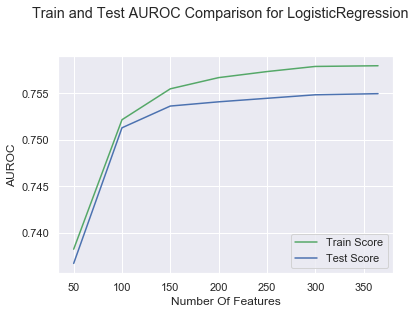

In [66]:
start_time_logit = time.time()
modeldetails(model_logit_best)
end_time_logit = time.time()
time_taken_logit = end_time_logit - start_time_logit
print("The total time taken to find the LR model with the optimum # of features is --- %s seconds ---" % (time_taken_logit))

### Running the Logistic Regresson Model (with best params) with top 150 features for optimum results

Train Feature Data Shape :(206032, 150)
Test Feature Data Shape :(101479, 150)
Train Target Data Shape :(206032,)
Test Target Data Shape :(101479,)


Train Data Accuracy Score : 0.9193
Train Data Precision Score : 0.5032
Train Data Recall Score : 0.0192
Train Data F1 Score : 0.0369


Train Data Confusion Matrix



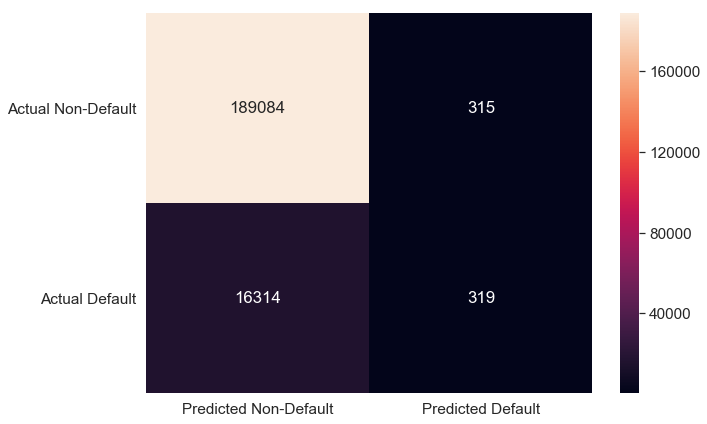



Train Data ROC Curve



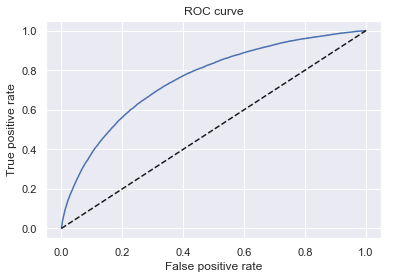

Train Data AUROC

0.7555


Test Data Accuracy Score : 0.9194
Test Data Precision Score : 0.5177
Test Data Recall Score : 0.0197
Test Data F1 Score : 0.0379


Test Data Confusion Matrix



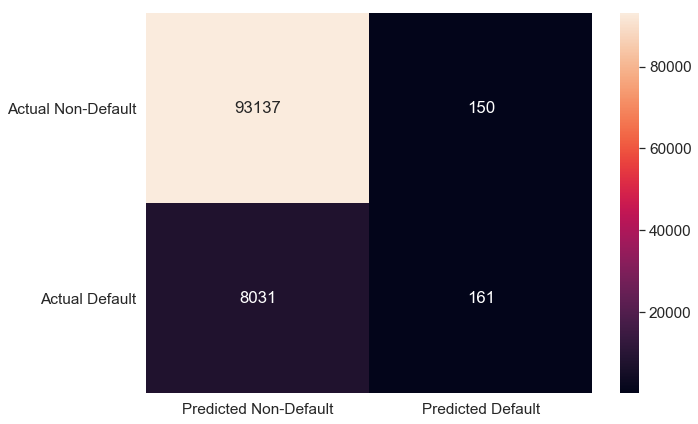



Test Data ROC Curve



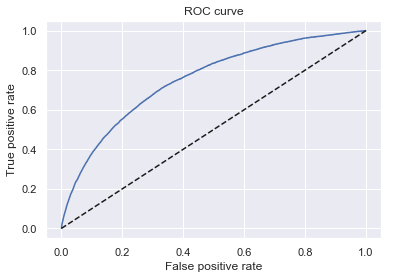

Test Data AUROC

0.7524


In [60]:
logit_finalmodel_matrix = finalmodelperformance(150,model_logit_best.best_estimator_, 0.5)

### Evaluating Random Forest model (with best parameters) with different # of features

Printing the mean test scores for RandomForestClassifier model
[0.73330929 0.73668107 0.73588589 0.73529045 0.73385777 0.73550193
 0.73639476 0.73665409 0.73375211 0.73315986 0.73399676 0.73534649
 0.73252718 0.73215884 0.73378986 0.73264428 0.73403635 0.73719348
 0.73673678 0.73740983 0.73630652 0.73756867 0.73562911 0.73755177
 0.73334923 0.73518254 0.73591871 0.73418962 0.72958811 0.73138554
 0.73369313 0.73278601 0.73399135 0.73827165 0.7357349  0.73673844
 0.73753515 0.734993   0.73623282 0.73633934 0.73308588 0.7338711
 0.7344278  0.7341096  0.73074594 0.73423868 0.73331787 0.73308895
 0.73606134 0.73661991 0.73853385 0.73735926 0.73475347 0.73703288
 0.73612397 0.73693529 0.73348419 0.73467917 0.73528726 0.73444689
 0.7317205  0.73287154 0.73227455 0.73253642 0.73371734 0.73630852
 0.7358716  0.73614818 0.73222341 0.73562676 0.73708027 0.73755428
 0.7347244  0.73552079 0.73467964 0.73425873 0.7291665  0.73210451
 0.73237348 0.73400758 0.73456013 0.73807636 0.73865147 0.73637763


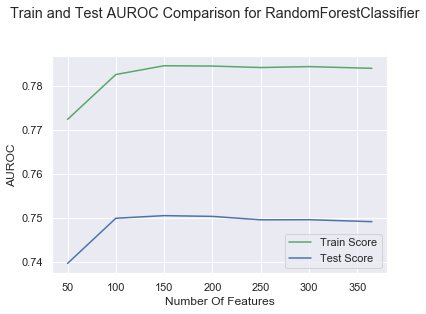

In [31]:
start_time_rf = time.time()
modeldetails(model_rf_best)
end_time_rf = time.time()
time_taken_rf = end_time_rf - start_time_rf
print("The total time taken to find the RF model with the optimum # of features is --- %s seconds ---" % (time_taken_rf))

### Running the Random Forest Model (with best params) with top 150 features for optimum results

Train Feature Data Shape :(206032, 150)
Test Feature Data Shape :(101479, 150)
Train Target Data Shape :(206032,)
Test Target Data Shape :(101479,)


Train Data Accuracy Score : 0.9193
Train Data Precision Score : 0.0000
Train Data Recall Score : 0.0000
Train Data F1 Score : 0.0000


Train Data Confusion Matrix



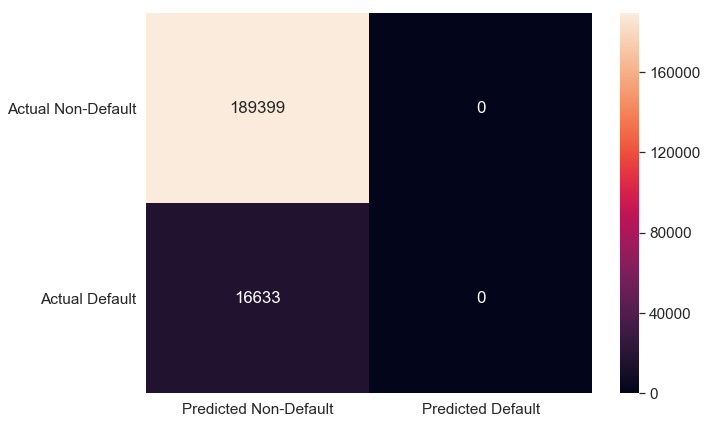



Train Data ROC Curve



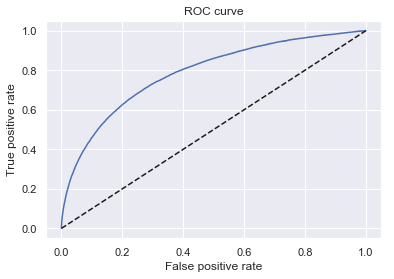

Train Data AUROC

0.7860


Test Data Accuracy Score : 0.9193
Test Data Precision Score : 0.0000
Test Data Recall Score : 0.0000
Test Data F1 Score : 0.0000


Test Data Confusion Matrix



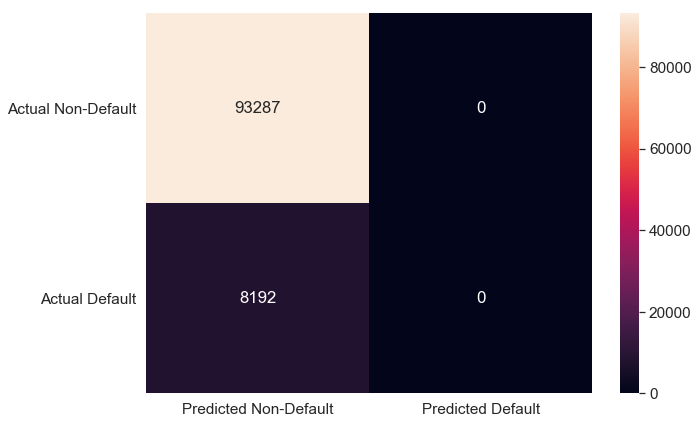



Test Data ROC Curve



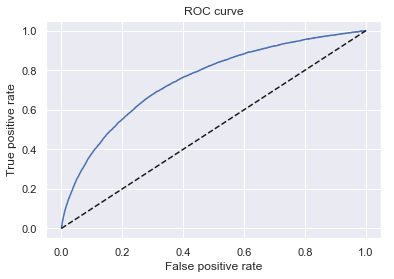

Test Data AUROC

0.7501


In [53]:
rf_finalmodel_matrix = finalmodelperformance(150,model_rf_best.best_estimator_,0.5)

### Evaluating Light GBM model (with best parameters) with different # of top features

Printing the mean test scores for LGBMClassifier model
[0.73398818 0.73398818 0.73444757 ... 0.66120591 0.65127446 0.65127446]


Printing the best parameters for the grid search performed on LGBMClassifier as the base model
{'boosting_type': 'gbdt', 'colsample_bytree': 0.66, 'learning_rate': 0.08, 'max_bin': 200, 'max_depth': 3, 'num_leaves': 100, 'objective': 'binary', 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.7}


Printing the best scores returned by the grid search performed on LGBMClassifier as the base model
0.7414960622863489


Comparing the performance of the best LGBMClassifier model with different number of features....

Number of subfeatures for this iteration is 50
Trainig Dataset Shape : (215257, 50)
Test Dataset Shape : (92254, 50)
The AUROC score for training data set is: 0.75705
The AUROC score on the test data set is: 0.74667
Iteration number 1 is now complete


Number of subfeatures for this iteration is 100
Trainig Dataset Shape : (215257, 100)
Test Dataset Shap

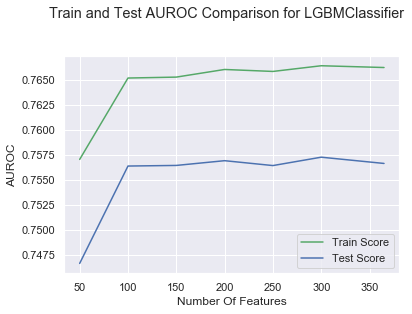

In [36]:
start_time_lgbm = time.time()
modeldetails(model_lgbm_best)
end_time_lgbm = time.time()
time_taken_lgbm = end_time_lgbm - start_time_lgbm
print("The total time taken to find the LGBM model with the optimum # of features is --- %s seconds ---" % (time_taken_lgbm))

### Running the Light GBM (with best params) with 150 top features for optimum results

Train Feature Data Shape :(206032, 150)
Test Feature Data Shape :(101479, 150)
Train Target Data Shape :(206032,)
Test Target Data Shape :(101479,)


Train Data Accuracy Score : 0.9195
Train Data Precision Score : 0.6738
Train Data Recall Score : 0.0057
Train Data F1 Score : 0.0113


Train Data Confusion Matrix



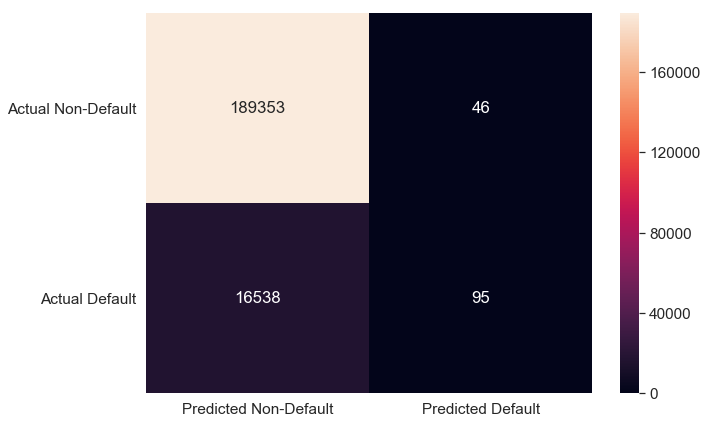



Train Data ROC Curve



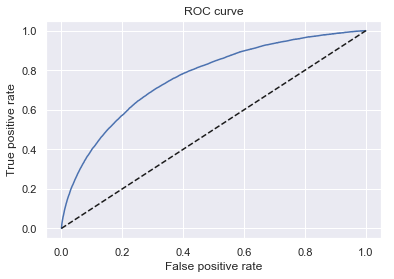

Train Data AUROC

0.7647


Test Data Accuracy Score : 0.9196
Test Data Precision Score : 0.7013
Test Data Recall Score : 0.0066
Test Data F1 Score : 0.0131


Test Data Confusion Matrix



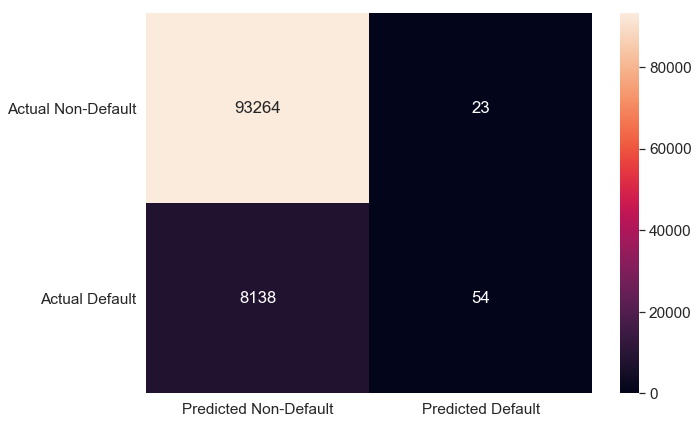



Test Data ROC Curve



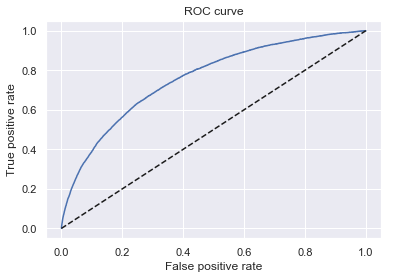

Test Data AUROC

0.7587


In [50]:
lgbm_finalmodel_matrix = finalmodelperformance(150,model_lgbm_best.best_estimator_,0.5)

Train Feature Data Shape :(206032, 200)
Test Feature Data Shape :(101479, 200)
Train Target Data Shape :(206032,)
Test Target Data Shape :(101479,)


Train Data Accuracy Score : 0.9196
Train Data Precision Score : 0.7310
Train Data Recall Score : 0.0064
Train Data F1 Score : 0.0126


Train Data Confusion Matrix



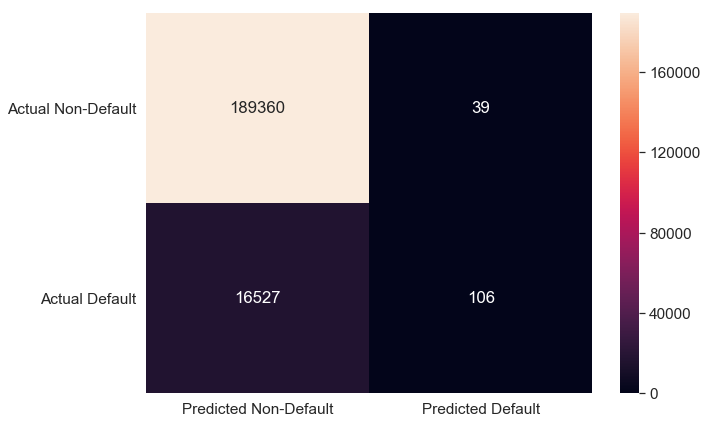



Train Data ROC Curve



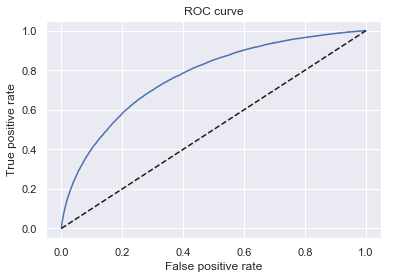

Train Data AUROC

0.7682


Test Data Accuracy Score : 0.9193
Test Data Precision Score : 0.5441
Test Data Recall Score : 0.0045
Test Data F1 Score : 0.0090


Test Data Confusion Matrix



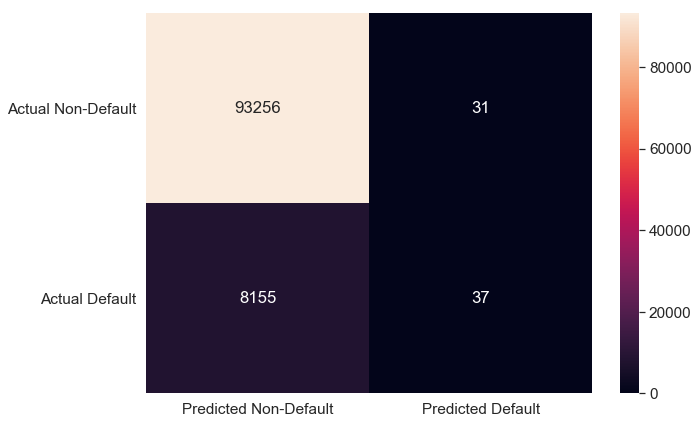



Test Data ROC Curve



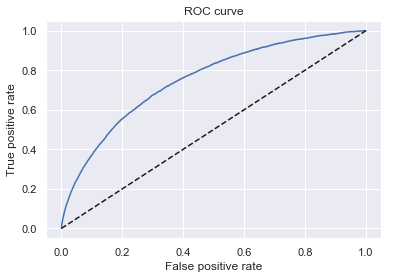

Test Data AUROC

0.7517


In [71]:
lgbm_finalmodel_matrix = finalmodelperformance(200,model_lgbm_best.best_estimator_,0.5)

### Evaluating XGBoost model with best parameters with different # of top features

Printing the mean test scores for XGBClassifier model
[0.7359856  0.73500496 0.73410959 0.73314656 0.72879298 0.72551313
 0.72287514 0.72011489 0.71798152 0.71444357 0.71146389 0.70894492
 0.7089294  0.70796167 0.7081157  0.7081157  0.73398262 0.73191609
 0.72995305 0.72739702 0.72197482 0.71862242 0.71405636 0.7116394
 0.71157387 0.70954655 0.70902825 0.70902825 0.70894016 0.70894016
 0.70894016 0.70894016 0.73182837 0.72952884 0.7274323  0.72499433
 0.71490586 0.71128559 0.70743842 0.70540808 0.70702385 0.70688811
 0.70688811 0.70688811 0.70447762 0.70447762 0.70447762 0.70447762
 0.72939241 0.72549572 0.72252238 0.71877099 0.7102979  0.70658781
 0.70454453 0.70454453 0.70414418 0.70414418 0.70414418 0.70414418
 0.70589769 0.70589769 0.70589769 0.70589769 0.73579533 0.73484835
 0.73386357 0.73288928 0.72764786 0.72496892 0.72353133 0.72075788
 0.71704838 0.71471842 0.71097749 0.70944798 0.71205894 0.71217098
 0.71217098 0.71217098 0.73379141 0.73161325 0.72954037 0.72788858
 0.720126

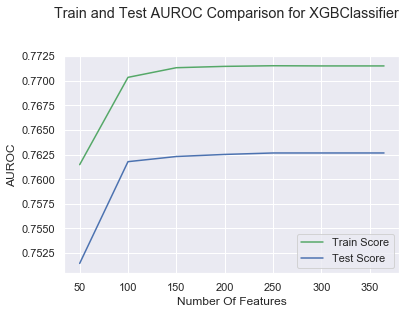

In [38]:
start_time_xgb = time.time()
modeldetails(model_xgb_best)
end_time_xgb = time.time()
time_taken_xgb = end_time_xgb - start_time_xgb
print("The total time taken to find the XGB model with the optimum # of features is --- %s seconds ---" % (time_taken_xgb))

### Running the XGBoost (with best params) with 150 top features for optimum results

Train Feature Data Shape :(206032, 150)
Test Feature Data Shape :(101479, 150)
Train Target Data Shape :(206032,)
Test Target Data Shape :(101479,)


Train Data Accuracy Score : 0.9198
Train Data Precision Score : 0.6687
Train Data Recall Score : 0.0135
Train Data F1 Score : 0.0264


Train Data Confusion Matrix



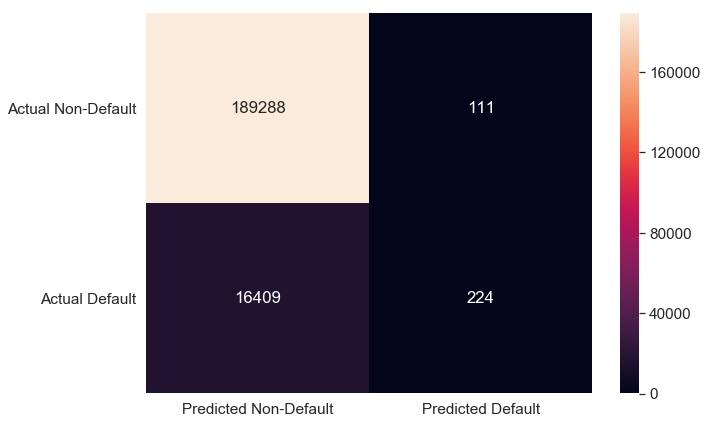



Train Data ROC Curve



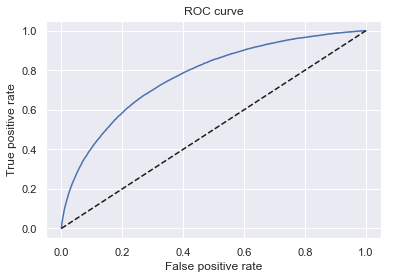

Train Data AUROC

0.7701


Test Data Accuracy Score : 0.9198
Test Data Precision Score : 0.6374
Test Data Recall Score : 0.0142
Test Data F1 Score : 0.0277


Test Data Confusion Matrix



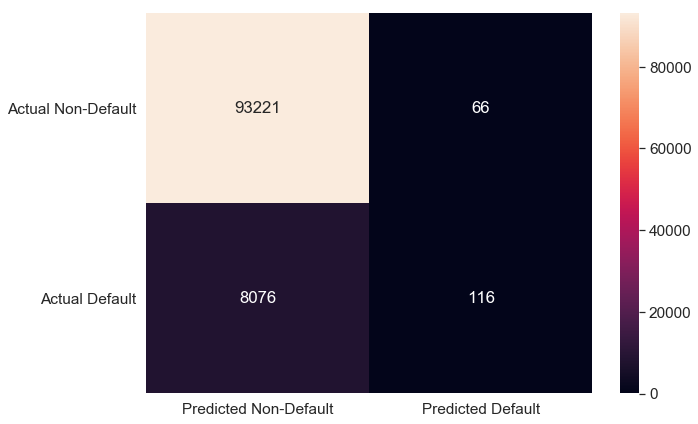



Test Data ROC Curve



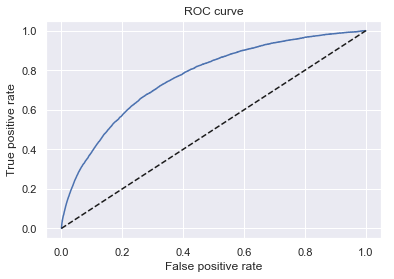

Test Data AUROC

0.7655


In [56]:
xgb_finalmodel_matrix = finalmodelperformance(150,model_xgb_best.best_estimator_,0.5)

### Running the XGB (with best params) with 150 top features and default probability threshhold as 0.4

Train Feature Data Shape :(206032, 150)
Test Feature Data Shape :(101479, 150)
Train Target Data Shape :(206032,)
Test Target Data Shape :(101479,)


Train Data Accuracy Score : 0.9199
Train Data Precision Score : 0.5505
Train Data Recall Score : 0.0429
Train Data F1 Score : 0.0796


Train Data Confusion Matrix



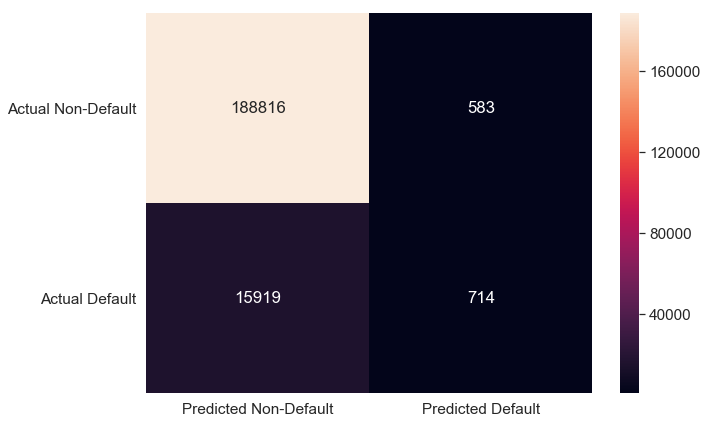



Train Data ROC Curve



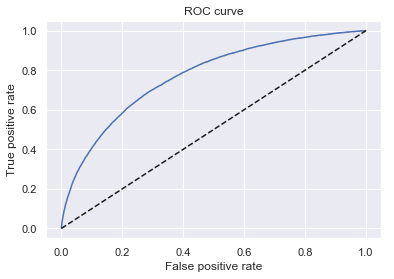

Train Data AUROC

0.7706


Test Data Accuracy Score : 0.9192
Test Data Precision Score : 0.4971
Test Data Recall Score : 0.0413
Test Data F1 Score : 0.0762


Test Data Confusion Matrix



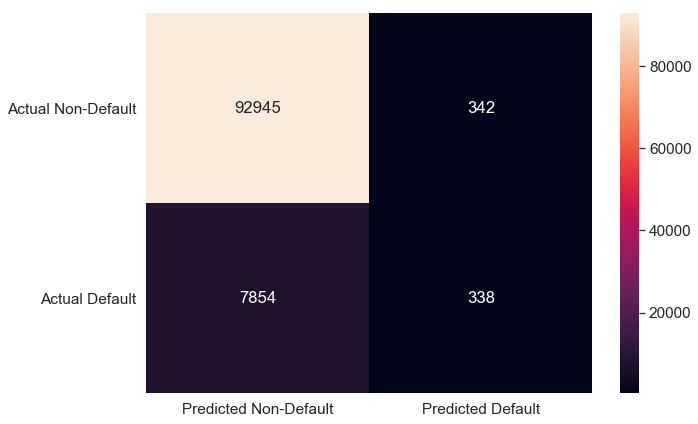



Test Data ROC Curve



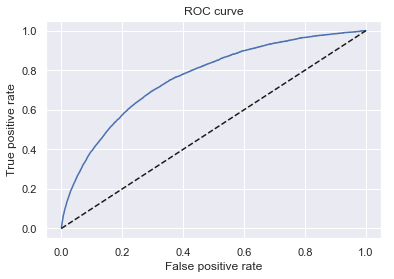

Test Data AUROC

0.7636


In [57]:
xgb_finalmodel_matrix = finalmodelperformance(150,model_xgb_best.best_estimator_,0.4)